# I. Reading the data
For work we used Google colab and read data from the Google Drive, to used it on your PC, specify the path to the data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#We worked in GoogleColab and load data from GoogleDrive since our laptops don't have enought memory to work with this amount of data#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("/content/drive/MyDrive/Project/DadosPreprocessados")

In [4]:
#Read data to the dataframes#
df_datasources = pd.read_csv("datasources_p.csv")
df_series = pd.read_csv("series_p.csv")
df_seriesdata = pd.read_csv("seriesdata_p.csv", low_memory = False)
df_sourcesandseries = pd.read_csv("SourcesAndSeries.csv")

# II. Data Wrangling


In [ ]:
#2.1 Decide the format of your data.
# We use data in the long format

In [5]:
#2.2 Add extra columns for simplifying understanding of the series variable, namely
#    by splitting the series variable standard name of the form
#    CALCULATION_METHOD(DATATYPE PERIOD) into its parts

#Breack seriesveriable_standartname to three columns: calculation_method, datatype, period#
df_series['seriesvariable_standardname'] = df_series['seriesvariable_standardname'].str.replace('(',' ', regex = False).str.replace(')', '', regex = False).str.replace('PT', '', regex=False)
df_series[['calculation_method', 'data_name', 'period']] = df_series['seriesvariable_standardname'].str.split(' ', n = 2, expand = True)

#Drop old columns with names
df_series = df_series.drop('seriesvariable_standardname', axis=1)
df_series = df_series.drop('seriesvariable_longname', axis=1)

## Merging dataframes:

In [6]:
#Add information from df_series to the main dataframe#

df_seriesdata = pd.merge(df_seriesdata, df_series[['series_id','calculation_method', 'data_name','period', 'unit_symbol']], on = 'series_id')

In [7]:
#Add information from df_datasources to the main datafraime#

df_seriesdata = pd.merge(df_seriesdata, df_datasources[['datasource_id', 'datasource_name', 'datasourcetype_name','longitude','latitude', 'datasource_externalid']], on = 'datasource_externalid', how = 'left')

In [8]:
#2.3 Additionally, check If there are any duplicates, and try to understand why,
#    suggesting an appropriate duplicate removal strategy

#Drop duplicates, counting as duplicates rows with the same values of timestamp and series_id#
df_seriesdata = df_seriesdata.drop_duplicates(subset=['seriesdata_timestamp', 'series_id'])
df_seriesdata = df_seriesdata.drop_duplicates(subset=['seriesdata_timestamp', 'data_name', 'datasource_id', 'calculation_method'])

In [9]:
#2.4 Perform an analysis of missing values in the way you find more convenient

#We can not merge series from unknown source or unknow id with other series, so we drop null values
df_seriesdata = df_seriesdata.dropna(subset = ['datasource_id', 'series_id'], how = 'any')

In [10]:
#Analysis of missing values
df_seriesdata.groupby(['data_name', 'calculation_method'])['Real Value'].apply(lambda x: x.isnull().sum())

data_name                       calculation_method
air_temperature                 max                    15785
                                mean                   35160
                                min                    15785
dew_point_depression            mean                   45093
dew_point_temperature           mean                   42447
                                min                     4029
leaf_wetness                    accumulated            38497
precipitation_amount            sum                    30530
reference_evapotranspiration    mean                    9521
relative_humidity               mean                   35141
soil_temperature                max                     3386
                                mean                    3389
                                min                     3389
solar_irradiance                max                    11766
                                mean                   31021
surface_air_pressure            me

## Initial data processing

In [11]:
#Sort dataframe by series_id and time#
df_seriesdata.sort_values(['series_id', 'seriesdata_timestamp'], inplace = True)

In [12]:
#Describe values of datatypes to find anomaly values#
df_seriesdata[['data_name','calculation_method', 'Real Value']].groupby(['data_name','calculation_method']).describe()

Real Value               \
                                                       count         mean   
data_name                      calculation_method                           
air_temperature                max                  468751.0    15.550609   
                               mean                 717783.0    15.464575   
                               min                  468751.0    15.245184   
dew_point_depression           mean                 619534.0     6.296630   
dew_point_temperature          mean                 706187.0     9.419174   
                               min                   65657.0    12.516688   
leaf_wetness                   accumulated          714931.0     5.967456   
precipitation_amount           sum                  722898.0     0.017544   
reference_evapotranspiration   mean                     12.0     0.726454   
relative_humidity              mean                 717802.0    69.818660   
soil_temperature               max                   66785.0    17.287147   
                               mean                  66782.0    17.118658   
                               min                   66782.0    17.017036   
solar_irradiance               max                  403084.0   187.120588   
                               mean                 652236.0   164.357648   
surface_air_pressure           mean                 407010.0  1014.706467   
water_vapor_saturation_deficit mean                  46462.0     0.331360   
wind_from_direction            max_wind_speed       318548.0   170.192114   
                               mean                 567605.0   172.857153   
wind_speed                     max                  722899.0     2.559927   
                               mean                 722903.0     0.884591   

                                                                            \
                                                          std          min   
data_name                      calculation_method                            
air_temperature                max                   5.416750     -6.10000   
                               mean                  5.286861     -6.10000   
                               min                   5.371878    -67.80000   
dew_point_depression           mean                  4.120163     -0.05000   
dew_point_temperature          mean                  5.304612    -15.40000   
                               min                   4.468998     -7.30000   
leaf_wetness                   accumulated           6.944855     -1.00000   
precipitation_amount           sum                   0.173305      0.00000   
reference_evapotranspiration   mean                  0.245387      0.41888   
relative_humidity              mean                 17.628330      7.00000   
soil_temperature               max                   4.978207      2.60000   
                               mean                  4.966603      2.50000   
                               min                   4.956484      2.40000   
solar_irradiance               max                 511.385430 -32768.00000   
                               mean                422.271064 -32768.00000   
surface_air_pressure           mean                  7.728783    985.20000   
water_vapor_saturation_deficit mean                  0.447063      0.00000   
wind_from_direction            max_wind_speed      119.786400      0.00000   
                               mean                122.426149      0.00000   
wind_speed                     max                   2.331817      0.00000   
                               mean                  1.052460      0.00000   

                                                                           \
                                                          25%         50%   
data_name                      calculation_method                           
air_temperature                max                   12.30000    15.50000   
                    

In [13]:
#Delete negetive values from Leaf Wetness and Sollar radiation#
df_seriesdata.loc[(df_seriesdata['data_name'] == 'leaf_wetness') & (df_seriesdata['Real Value'] < 0), 'Real Value'] = None
df_seriesdata.loc[(df_seriesdata['data_name'] == 'solar_irradiance') & (df_seriesdata['Real Value'] <= 0), 'Real Value'] = None
#Add 273 to temperature values to change to absolute temperature#
df_seriesdata.loc[df_seriesdata['data_name'].isin(['soil_temperature', 'dew_point_temperature', 'air_temperature']), 'Real Value'] += 273

In [14]:
# Our dataframe after initial processing
df_seriesdata

,datasource_externalid,series_id,datatype_id,seriesdata_timestamp,seriesdata_realvalue,Real Value,calculation_method,data_name,period,unit_symbol,datasource_id,datasource_name,datasourcetype_name,longitude,latitude
2084050,CABAzamb,1,1,01/01/2020 00:00:00,7.4,280.4,mean,air_temperature,15M,°C,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
2083567,CABAzamb,1,1,01/01/2020 00:15:00,6.6,279.6,mean,air_temperature,15M,°C,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
2083240,CABAzamb,1,1,01/01/2020 00:30:00,5.7,278.7,mean,air_temperature,15M,°C,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
2083847,CABAzamb,1,1,01/01/2020 00:45:00,7.1,280.1,mean,air_temperature,15M,°C,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
2083848,CABAzamb,1,1,01/01/2020 01:00:00,7.1,280.1,mean,air_temperature,15M,°C,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7580779,CPFQuint,2134,37,31/12/2021 22:45:00,15.5,15.5,mean,dew_point_depression,15m,°C,15,CPFQuint,Weather Station,"-9,1889048","39,325982"
7580780,CPFQuint,2134,37,31/12/2021 23:00:00,15.4,15.4,mean,dew_point_depression,15m,°C,15,CPFQuint,Weather Station,"-9,1889048","39,325982"
7580781,CPFQuint,2134,37,31/12/2021 23:15:00,15.4,15.4,mean,dew_point_depression,15m,°C,15,CPFQuint,Weather Station,"-9,1889048","39,325982"
7580782,CPFQuint,2134,37,31/12/2021 23:30:00,15.4,15.4,mean,dew_point_depression,15m,°C,15,CPFQuint,Weather Station,"-9,1889048","39,325982"


In [15]:
# 2.5 Define a function that allows you to plot easily the minimum, mean, maximum
#     values in period in a given time span

#Function for plotting series by series_id, agregated and resampled
def plot_series(df, series_id, aggregations, resample_period):
  grouped = df.groupby('series_id')
  for id in series_id:
    group = grouped.get_group(id)
    group['seriesdata_timestamp'] = pd.to_datetime(group['seriesdata_timestamp'])
    group.set_index('seriesdata_timestamp', inplace=True)
    group['Real Value'].resample(resample_period).agg(aggregations).plot(title=(group['calculation_method'][0] + ' ' + group['data_name'][0]))

<ipython-input-15-947bfcc56c32>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['seriesdata_timestamp'] = pd.to_datetime(group['seriesdata_timestamp'])
<ipython-input-15-947bfcc56c32>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['seriesdata_timestamp'] = pd.to_datetime(group['seriesdata_timestamp'])


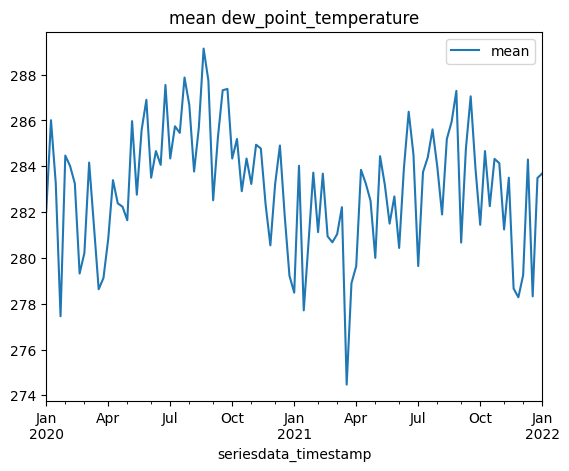

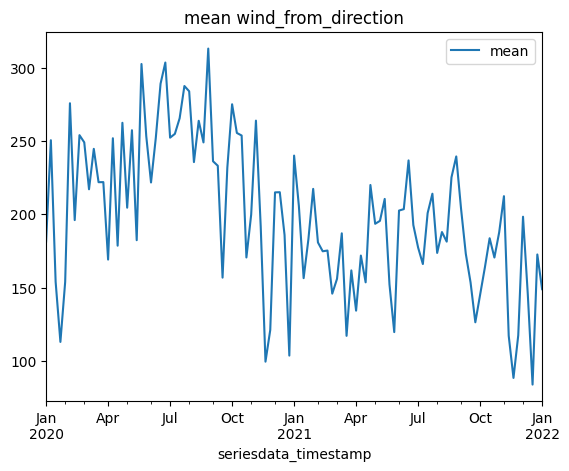

In [16]:
#Plotting series
plot_series(df_seriesdata, [5, 11], ['mean'], '1W')

In [17]:
# Transforming seriesdata_timestamp to datetime dtype (takes ~18m)
df_seriesdata['seriesdata_timestamp'] = pd.to_datetime(df_seriesdata['seriesdata_timestamp'])

In [18]:
df_1 = df_seriesdata.copy()
df_2 = df_seriesdata.copy()

# III. Data Agregation

In [ ]:
# Check number of recordings for each recording type
df_1.groupby(['data_name','calculation_method'])['Real Value'].count()

data_name              calculation_method
air_temperature        mean                  717783
dew_point_depression   mean                  619534
dew_point_temperature  mean                  706187
leaf_wetness           accumulated           714899
precipitation_amount   sum                   722898
relative_humidity      mean                  717802
solar_irradiance       mean                  333177
surface_air_pressure   mean                  407010
wind_speed             mean                  722903
Name: Real Value, dtype: int64

In [ ]:
# Describe variables:
df_1[['data_name','calculation_method', 'Real Value']].groupby(['data_name','calculation_method']).describe()

Real Value                           \
                                              count         mean         std   
data_name             calculation_method                                       
air_temperature       mean                 717783.0   288.464575    5.286861   
dew_point_depression  mean                 619534.0     6.296630    4.120163   
dew_point_temperature mean                 706187.0   282.419174    5.304612   
leaf_wetness          accumulated          714899.0     5.967767    6.944854   
precipitation_amount  sum                  722898.0     0.017544    0.173305   
relative_humidity     mean                 717802.0    69.818660   17.628330   
solar_irradiance      mean                 333177.0   328.143585  291.197035   
surface_air_pressure  mean                 407010.0  1014.706467    7.728783   
wind_speed            mean                 722903.0     0.884591    1.052460   

                                                                             \
                                             min      25%      50%      75%   
data_name             calculation_method                                      
air_temperature       mean                266.90   285.30   288.41   291.60   
dew_point_depression  mean                 -0.05     3.10     5.70     8.56   
dew_point_temperature mean                257.60   279.20   283.00   286.20   
leaf_wetness          accumulated           0.00     0.00     0.00    15.00   
precipitation_amount  sum                   0.00     0.00     0.00     0.00   
relative_humidity     mean                  7.00    58.00    70.00    83.00   
solar_irradiance      mean                  1.00    79.09   237.00   523.53   
surface_air_pressure  mean                985.20  1009.00  1014.90  1020.20   
wind_speed            mean                  0.00     0.00     0.40     1.30   

                                                   
                                              max  
data_name             calculation_method           
air_temperature       mean                 312.35  
dew_point_depression  mean                  41.10  
dew_point_temperature mean                 299.10  
leaf_wetness          accumulated           15.00  
precipitation_amount  sum                   35.28  
relative_humidity     mean                 100.00  
solar_irradiance      mean                1445.98  
surface_air_pressure  mean                1038.10  
wind_speed            mean                  12.50

In [ ]:
#Dropping mesurment types with small number of recordings
df_1 = df_1[df_1['calculation_method'].isin(['mean', 'accumulated', 'sum'])]
df_1 = df_1[~df_1['data_name'].isin(['soil_temperature', 'water_vapor_saturation_deficit', 'wind_from_direction', 'reference_evapotranspiration' ])]

In [ ]:
# Pivotting table to wide format, there for each datasource and time point there are values for all mesurments
df_1 = df_1.pivot(index=['datasource_id','seriesdata_timestamp'],columns='data_name', values = 'Real Value')

In [ ]:
# Dataframe
df_1

data_name                           air_temperature  dew_point_depression  \
datasource_id seriesdata_timestamp                                          
1             2020-01-01 00:00:00            280.40                  2.00   
              2020-01-01 00:15:00            279.60                  2.50   
              2020-01-01 00:30:00            278.70                  2.20   
              2020-01-01 00:45:00            280.10                  1.90   
              2020-01-01 01:00:00            280.10                  2.10   
...                                             ...                   ...   
30            2021-12-27 14:45:00            290.87                  4.37   
              2021-12-27 15:00:00            290.83                  4.33   
              2021-12-27 15:15:00            290.49                  4.29   
              2021-12-27 15:30:00            290.88                  4.18   
              2021-12-27 15:45:00            290.58                  4.18   

data_name                           dew_point_temperature  leaf_wetness  \
datasource_id seriesdata_timestamp                                        
1             2020-01-01 00:00:00                   278.4          14.0   
              2020-01-01 00:15:00                   277.1          14.0   
              2020-01-01 00:30:00                   276.5           NaN   
              2020-01-01 00:45:00                   278.2           NaN   
              2020-01-01 01:00:00                   278.0           NaN   
...                                                   ...           ...   
30            2021-12-27 14:45:00                   286.5           0.0   
              2021-12-27 15:00:00                   286.5           0.0   
              2021-12-27 15:15:00                   286.2           0.0   
              2021-12-27 15:30:00                   286.7           0.0   
              2021-12-27 15:45:00                   286.4           0.0   

data_name                           precipitation_amount  relative_humidity  \
datasource_id seriesdata_timestamp                                            
1             2020-01-01 00:00:00                    0.0              87.00   
              2020-01-01 00:15:00                    0.0              84.00   
              2020-01-01 00:30:00                    0.0              86.00   
              2020-01-01 00:45:00                    0.0              88.00   
              2020-01-01 01:00:00                    0.0              87.00   
...                                                  ...                ...   
30            2021-12-27 14:45:00                    0.0              75.42   
              2021-12-27 15:00:00                    0.0              75.70   
              2021-12-27 15:15:00                    0.0              75.85   
              2021-12-27 15:30:00                    0.0              76.21   
              2021-12-27 15:45:00                    0.0              76.34   

data_name                           solar_irradiance  surface_air_pressure  \
datasource_id seriesdata_timestamp                                           
1             2020-01-01 00:00:00                NaN                1022.7   
              2020-01-01 00:15:00                NaN                1022.7   
              2020-01-01 00:30:00                NaN                1022.8   
              2020-01-01 00:45:00                NaN                1022.5   
              2020-01-01 01:00:00                NaN                1022.5   
...                                              ...                   ...   
30            2021-12-27 14:45:00             394.61                   NaN   
              2021-12-27 15:00:00             186.16                   NaN   
              2021-12-27 15:15:00             185.33                   NaN   
              2021-12-27 15:30:00             143.37                   NaN   
              2021-12-27 15:45:00             125.66      

In [ ]:
# Creating groups by datasource_id
grouped = df_1.groupby('datasource_id')

In [ ]:
#3.1 Filling missing information using interpolation methods
#3.2 Aggregate the previous data hourly;
#3.3 If there are missing values at the hourly value, you can employ the same or
#    other interpolation methods to construct a new derived series

#  Break big dataframe to different dataframes by station id, interpolating and aggregating values by hour
#  and unite them again
df = pd.DataFrame()
for name, group in grouped:
  group = group.reset_index(level='datasource_id', drop=False) # Dropping datasource_id from index and creating a column with it
  group = group.interpolate(limit=94)   # Interpolating missing values with max limit of gap = 94 (one day)
  group = group.resample('1H').agg({'air_temperature':'mean', 'dew_point_depression':'mean',
                                   'dew_point_temperature': 'mean', 'leaf_wetness': 'sum', 'precipitation_amount':'sum',
                                   'relative_humidity': 'mean', 'wind_speed':'mean', 'solar_irradiance':'mean',
                                    'datasource_id': 'first'}).interpolate(method='akima')  # Resampling by hour and interpolating missing values
  group = group.dropna(how='any')  # Dropping None values
  group = group.reset_index('seriesdata_timestamp', drop=False)
  group = group.set_index(['datasource_id','seriesdata_timestamp'])
  if not group.empty:
    df = pd.concat([df,group], ignore_index=False)

In [ ]:
# Resulting dataframe
df

data_name                           air_temperature  dew_point_depression  \
datasource_id seriesdata_timestamp                                          
1.0           2020-01-01 10:00:00        287.152273              6.390152   
              2020-01-01 11:00:00        287.650000              6.775000   
              2020-01-01 12:00:00        287.450000              6.675000   
              2020-01-01 13:00:00        286.012500              5.572917   
              2020-01-01 14:00:00        285.075000              4.920833   
...                                             ...                   ...   
30.0          2021-12-27 11:00:00        290.767500              3.317500   
              2021-12-27 12:00:00        291.091667              3.966667   
              2021-12-27 13:00:00        291.103333              4.278333   
              2021-12-27 14:00:00        291.145000              4.495000   
              2021-12-27 15:00:00        290.695000              4.245000   

data_name                           dew_point_temperature  leaf_wetness  \
datasource_id seriesdata_timestamp                                        
1.0           2020-01-01 10:00:00              280.762121     52.500000   
              2020-01-01 11:00:00              280.875000     50.961538   
              2020-01-01 12:00:00              280.775000     49.423077   
              2020-01-01 13:00:00              280.439583     47.884615   
              2020-01-01 14:00:00              280.154167     46.346154   
...                                                   ...           ...   
30.0          2021-12-27 11:00:00              287.450000      0.000000   
              2021-12-27 12:00:00              287.125000      0.000000   
              2021-12-27 13:00:00              286.825000      0.000000   
              2021-12-27 14:00:00              286.650000      0.000000   
              2021-12-27 15:00:00              286.450000      0.000000   

data_name                           precipitation_amount  relative_humidity  \
datasource_id seriesdata_timestamp                                            
1.0           2020-01-01 10:00:00                    0.0          65.424242   
              2020-01-01 11:00:00                    0.0          63.750000   
              2020-01-01 12:00:00                    0.0          64.250000   
              2020-01-01 13:00:00                    0.0          68.885417   
              2020-01-01 14:00:00                    0.0          71.895833   
...                                                  ...                ...   
30.0          2021-12-27 11:00:00                    0.0          80.555000   
              2021-12-27 12:00:00                    0.0          77.287500   
              2021-12-27 13:00:00                    0.0          75.795000   
              2021-12-27 14:00:00                    0.0          74.735000   
              2021-12-27 15:00:00                    0.0          76.025000   

data_name                           wind_speed  solar_irradiance  
datasource_id seriesdata_timestamp                                
1.0           2020-01-01 10:00:00     0.875000        416.666667  
              2020-01-01 11:00:00     0.775000        320.000000  
              2020-01-01 12:00:00     0.400000        137.750000  
              2020-01-01 13:00:00     1.000000         33.750000  
              2020-01-01 14:00:00     0.000000         17.560811  
...                                        ...               ...  
30.0          2021-12-27 11:00:00     2.050000        392.375000  
              2021-12-27 12:00:00     2.616667        231.620833  
              2021-12-27 13:00:00     2.008333        391.241667  
              2021-12-27 14:00:00     3.925000        379.130000  
              2021-12-27 15:00:00     3.200000        160.130000  

[175155 rows x 8 columns]

In [ ]:
#3.4 Characterize daily each of your series with the number of missing values

# Check if there are missing values
df.isnull().any(axis=1).sum()

0

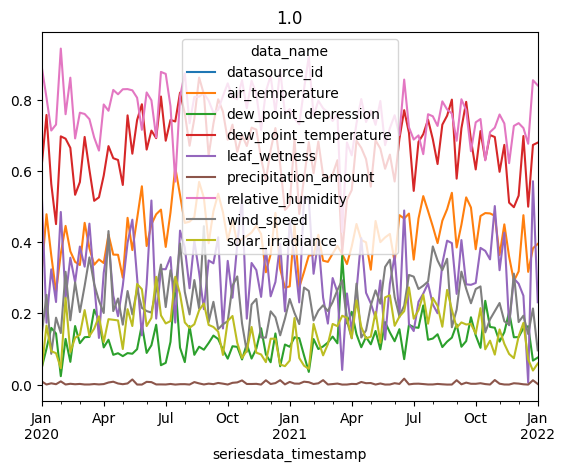

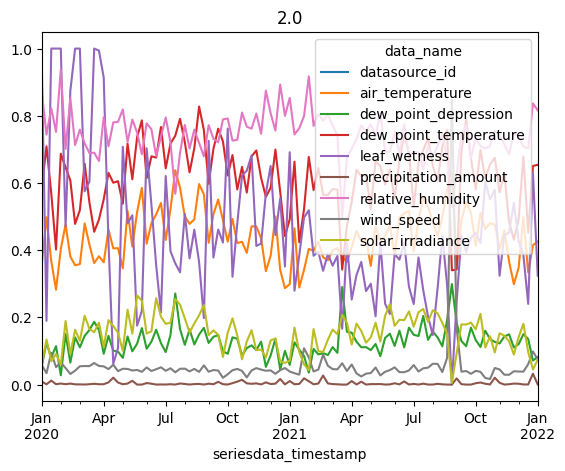

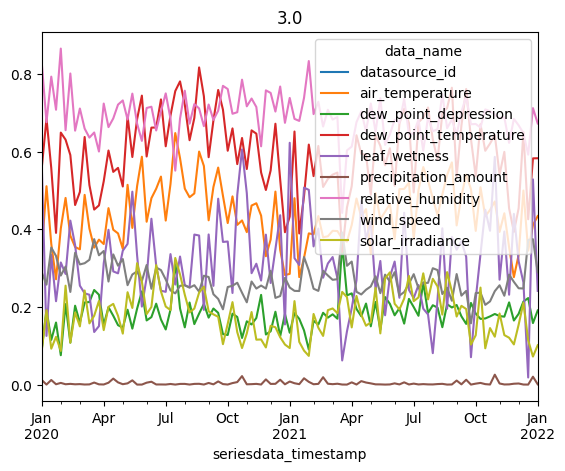

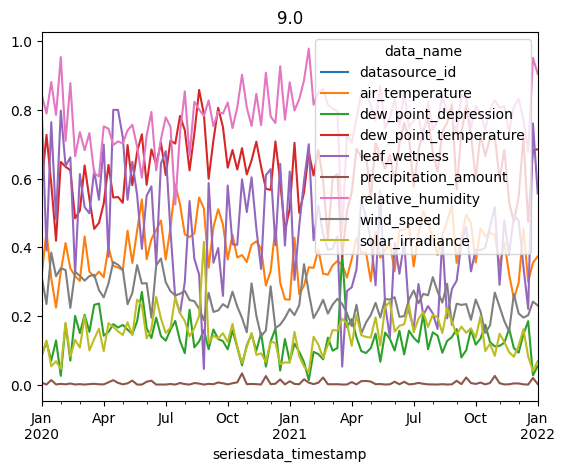

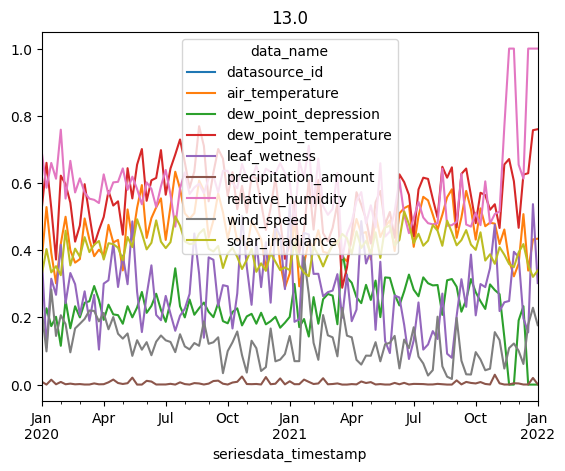

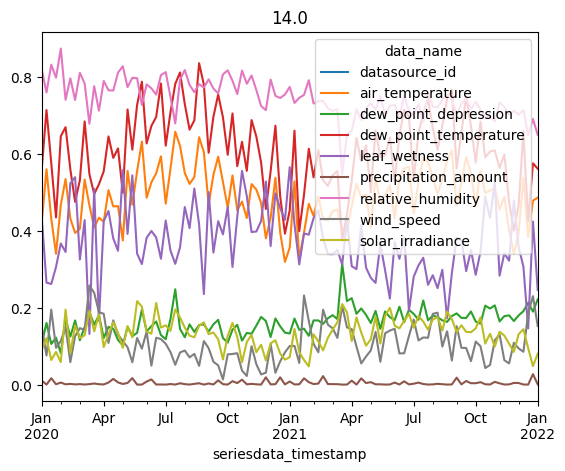

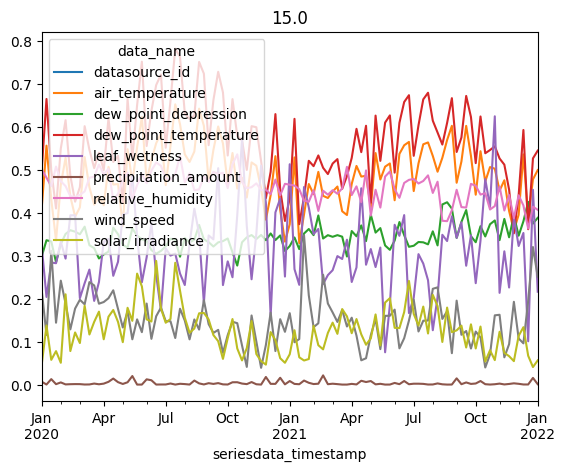

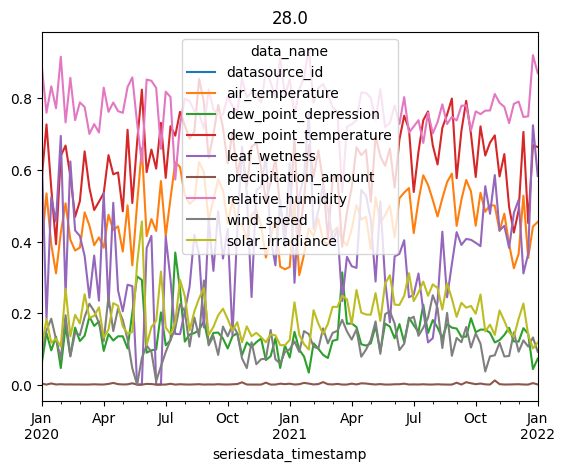

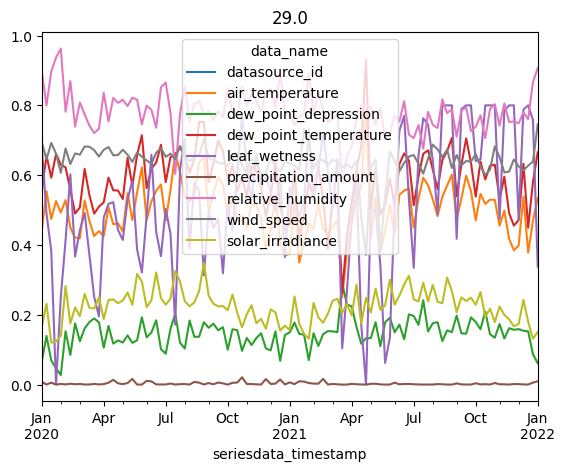

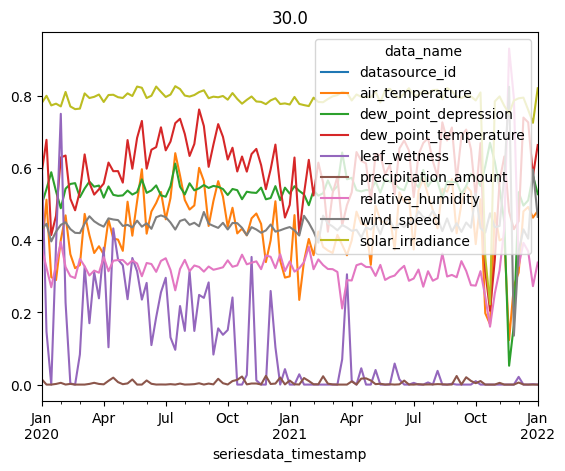

In [ ]:
#Ploting resampled measurments by each station
normalize = True
resample_period = '1W'

grouped = df.groupby('datasource_id')
for name, group in grouped:
  group = group.reset_index('datasource_id')
  if normalize:
    group = (group - group.min()) / (group.max() - group.min())
  group.resample(resample_period).mean().plot(title=str(name))

In [ ]:
#Check correlation between variables by station
station_id = 1
grouped = df.groupby('datasource_id')
group = grouped.get_group(station_id)
group.corr()

data_name,air_temperature,dew_point_depression,dew_point_temperature,leaf_wetness,precipitation_amount,relative_humidity,wind_speed,solar_irradiance
data_name,,,,,,,,
air_temperature,1.000000,0.430520,0.715066,-0.247940,-0.052121,-0.362982,0.264398,0.589390
dew_point_depression,0.430520,1.000000,-0.309444,-0.488903,-0.098510,-0.961238,0.208765,0.508966
dew_point_temperature,0.715066,-0.309444,1.000000,0.124684,0.022752,0.378481,0.111379,0.219928
leaf_wetness,-0.247940,-0.488903,0.124684,1.000000,0.168501,0.551006,-0.253998,-0.424804
precipitation_amount,-0.052121,-0.098510,0.022752,0.168501,1.000000,0.111738,0.011110,-0.072458
relative_humidity,-0.362982,-0.961238,0.378481,0.551006,0.111738,1.000000,-0.234966,-0.506648
wind_speed,0.264398,0.208765,0.111379,-0.253998,0.011110,-0.234966,1.000000,0.400224
solar_irradiance,0.589390,0.508966,0.219928,-0.424804,-0.072458,-0.506648,0.400224,1.000000


# IV. Data Understanding

In [19]:
# We have 11 stations

station_nbr = len(df_seriesdata['datasource_externalid'].unique())
print(station_nbr)

station_l = df_2['datasource_id'].unique()
print(station_l)

11
[ 1  2  3 13 14 15 16  9 28 29 30]


In [20]:
# We have 13 parameters, we have to collect summary about parameters 1, 3, 4, 6, and 8 for correlation analysis

matrix = df_2[['datatype_id', 'data_name']]
clean_matrix = matrix.drop_duplicates(subset=['datatype_id', 'data_name'])
sorted_matrix = clean_matrix.sort_values('datatype_id').reset_index(drop=True)
sorted_matrix

,datatype_id,data_name
0,1,air_temperature
1,2,soil_temperature
2,3,precipitation_amount
3,4,wind_speed
4,5,dew_point_temperature
5,6,leaf_wetness
6,7,water_vapor_saturation_deficit
7,8,relative_humidity
8,9,solar_irradiance
9,12,reference_evapotranspiration


In [21]:
# Function for aggregating data by series in which the parameter was measured, where n=datatype_id, m=datasource_id, k=series_id

def station_data_aggregation_series(df, n, m):
  df_station_n = df[df['datatype_id'] == n].copy()
  df_station_nm = df_station_n[df_station_n['datasource_id'] == m].copy()
  series = list(df_station_nm['series_id'].unique())
  df_series_list = []
  if len(series) == 0:
    return df_series_list
  elif len(series) == 1:
    df_station_nmk = df_station_nm[df_station_nm['series_id'] == int(series[0])].copy()
    df_station_nmk.set_index('seriesdata_timestamp', inplace=True)
    df_station_nmk['seriesdata_realvalue'] = df_station_nmk['seriesdata_realvalue'].interpolate(method='linear', limit = 96)
    df_station_nmk = df_station_nmk.drop('Real Value', axis=1)
    df_station_nmk.dropna(inplace=True)
    df_series_list.append(df_station_nmk)
  else:
    for k in range(len(series)):
      df_station_nmk = df_station_nm[df_station_nm['series_id'] == int(series[k])].copy()
      df_station_nmk.set_index('seriesdata_timestamp', inplace=True)
      df_station_nmk['seriesdata_realvalue'] = df_station_nmk['seriesdata_realvalue'].interpolate(method='linear', limit = 96)
      df_station_nmk = df_station_nmk.drop('Real Value', axis=1)
      df_station_nmk.dropna(inplace=True)
      df_series_list.append(df_station_nmk)

  return df_series_list

In [22]:
# Function for aggregating data by measured parameter, where n=datatype_id

def station_data_aggregation_global(df, n):
    df_copy = df[df['datatype_id'] == n].copy()
    df_copy.set_index('seriesdata_timestamp', inplace=True)
    df_copy['seriesdata_realvalue'] = df_copy['seriesdata_realvalue'].interpolate(method='linear', limit = 96)
    df_copy = df_copy.drop('Real Value', axis=1)
    df_copy.dropna(inplace=True)

    return df_copy

In [23]:
# 4.1 Perform the analysis globally and for each individual station, for the major weather variables
# Firstly, we collect data for each measured parameter (the data is presented as a list of df)

param_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 18, 24, 37]
df_interpolated_list = []

for param in param_list:
    df_interpolated = station_data_aggregation_global(df_seriesdata, param)
    df_interpolated_list.append(df_interpolated)

In [24]:
# Thus, when accessing the list by parameter index, we get summary information on the values ​​of a particular parameter for all stations

df_interpolated_list[7]

,datasource_externalid,series_id,datatype_id,seriesdata_realvalue,calculation_method,data_name,period,unit_symbol,datasource_id,datasource_name,datasourcetype_name,longitude,latitude
seriesdata_timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,CABAzamb,4,8,87.00,mean,relative_humidity,15M,%,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
2020-01-01 00:15:00,CABAzamb,4,8,84.00,mean,relative_humidity,15M,%,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
2020-01-01 00:30:00,CABAzamb,4,8,86.00,mean,relative_humidity,15M,%,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
2020-01-01 00:45:00,CABAzamb,4,8,88.00,mean,relative_humidity,15M,%,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
2020-01-01 01:00:00,CABAzamb,4,8,87.00,mean,relative_humidity,15M,%,1,CABAzamb,Weather Station,"-9,1868985","39,2814793"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 22:45:00,612,516,8,76.92,mean,relative_humidity,15M,%,30,V. Lapa,Weather Station,"-9,068125","39,265137"
2020-12-31 23:00:00,612,516,8,75.48,mean,relative_humidity,15M,%,30,V. Lapa,Weather Station,"-9,068125","39,265137"
2020-12-31 23:15:00,612,516,8,73.53,mean,relative_humidity,15M,%,30,V. Lapa,Weather Station,"-9,068125","39,265137"


In [25]:
# leaf_wetness by station

stations_id_l = list(df_interpolated_list[5]['series_id'].unique())
s = []
df_stations_list = []

for i in range(len(stations_id_l)):
  df = df_interpolated_list[5][df_interpolated_list[5]['series_id'] == int(stations_id_l[i])].copy()
  df_stations_list.append(df)

In [26]:
# leaf_wetness by station, 11 stations

df_stations_list[7]

,datasource_externalid,series_id,datatype_id,seriesdata_realvalue,calculation_method,data_name,period,unit_symbol,datasource_id,datasource_name,datasourcetype_name,longitude,latitude
seriesdata_timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,294,497,6,15.0,accumulated,leaf_wetness,15M,min,9,Ramalheira,Weather Station,"-9,103403","39,29128"
2020-01-01 00:15:00,294,497,6,15.0,accumulated,leaf_wetness,15M,min,9,Ramalheira,Weather Station,"-9,103403","39,29128"
2020-01-01 00:30:00,294,497,6,15.0,accumulated,leaf_wetness,15M,min,9,Ramalheira,Weather Station,"-9,103403","39,29128"
2020-01-01 00:45:00,294,497,6,15.0,accumulated,leaf_wetness,15M,min,9,Ramalheira,Weather Station,"-9,103403","39,29128"
2020-01-01 01:00:00,294,497,6,15.0,accumulated,leaf_wetness,15M,min,9,Ramalheira,Weather Station,"-9,103403","39,29128"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 22:45:00,294,497,6,0.0,accumulated,leaf_wetness,15M,min,9,Ramalheira,Weather Station,"-9,103403","39,29128"
2021-12-31 23:00:00,294,497,6,0.0,accumulated,leaf_wetness,15M,min,9,Ramalheira,Weather Station,"-9,103403","39,29128"
2021-12-31 23:15:00,294,497,6,0.0,accumulated,leaf_wetness,15M,min,9,Ramalheira,Weather Station,"-9,103403","39,29128"


In [27]:
# Temperature by station

st_id_l = list(df_interpolated_list[0]['series_id'].unique())
s = []
df_stations_list_temp = []

for i in range(len(st_id_l)):
  df = df_interpolated_list[0][df_interpolated_list[0]['series_id'] == int(st_id_l[i])].copy()
  df_stations_list_temp.append(df)

In [28]:
# Temperature by station, 11 stations

df_stations_list_temp[5]

,datasource_externalid,series_id,datatype_id,seriesdata_realvalue,calculation_method,data_name,period,unit_symbol,datasource_id,datasource_name,datasourcetype_name,longitude,latitude
seriesdata_timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,Coopval01VV,17,1,3.8,min,air_temperature,15M,°C,2,Coopval01VV,Weather Station,"-9,0422469","39,2485189"
2020-01-01 00:15:00,Coopval01VV,17,1,3.7,min,air_temperature,15M,°C,2,Coopval01VV,Weather Station,"-9,0422469","39,2485189"
2020-01-01 00:30:00,Coopval01VV,17,1,3.7,min,air_temperature,15M,°C,2,Coopval01VV,Weather Station,"-9,0422469","39,2485189"
2020-01-01 00:45:00,Coopval01VV,17,1,3.7,min,air_temperature,15M,°C,2,Coopval01VV,Weather Station,"-9,0422469","39,2485189"
2020-01-01 01:00:00,Coopval01VV,17,1,3.7,min,air_temperature,15M,°C,2,Coopval01VV,Weather Station,"-9,0422469","39,2485189"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 22:45:00,Coopval01VV,17,1,13.4,min,air_temperature,15M,°C,2,Coopval01VV,Weather Station,"-9,0422469","39,2485189"
2021-12-31 23:00:00,Coopval01VV,17,1,13.3,min,air_temperature,15M,°C,2,Coopval01VV,Weather Station,"-9,0422469","39,2485189"
2021-12-31 23:15:00,Coopval01VV,17,1,13.3,min,air_temperature,15M,°C,2,Coopval01VV,Weather Station,"-9,0422469","39,2485189"


In [29]:
# By using function for aggregating data by series in which the parameter was measured we can make a
# a three-dimensional array, in which the first argument is the station, the second is the measured parameter,
# the third is the measurement series of a specific parameter
#
# Such a format of data aggregation will allow measuring the correlations between all the parameters of interest
# of all stations in a cycle, taking into account the fact that the same type of measurement at the selected station
# could be carried out in different time intervals (different series)

stations_l = [3, 9, 1, 2, 30, 29, 28, 16, 15, 14, 13]
datatype_l = [1, 2, 3, 4, 5, 7, 8, 9, 12, 18, 24, 37]

df_interpolated_list = []
stations = []

for station in stations_l:
  for datatype in datatype_l:
    df_interpolated = station_data_aggregation_series(df_seriesdata, datatype, station)
    df_interpolated_list.append(df_interpolated)
  stations.append(df_interpolated_list)

In [30]:
# Example of the above logic
# station 3, param - relative_humidity, series_id - 32

stations[1][6][0]

,datasource_externalid,series_id,datatype_id,seriesdata_realvalue,calculation_method,data_name,period,unit_symbol,datasource_id,datasource_name,datasourcetype_name,longitude,latitude
seriesdata_timestamp,,,,,,,,,,,,,
2020-01-01 00:00:00,Coopval03VN,32,8,77.0,mean,relative_humidity,15M,%,3,Coopval03VN,Weather Station,"-9,0943944","39,2030109"
2020-01-01 00:15:00,Coopval03VN,32,8,77.0,mean,relative_humidity,15M,%,3,Coopval03VN,Weather Station,"-9,0943944","39,2030109"
2020-01-01 00:30:00,Coopval03VN,32,8,77.0,mean,relative_humidity,15M,%,3,Coopval03VN,Weather Station,"-9,0943944","39,2030109"
2020-01-01 00:45:00,Coopval03VN,32,8,77.0,mean,relative_humidity,15M,%,3,Coopval03VN,Weather Station,"-9,0943944","39,2030109"
2020-01-01 01:00:00,Coopval03VN,32,8,77.0,mean,relative_humidity,15M,%,3,Coopval03VN,Weather Station,"-9,0943944","39,2030109"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 22:45:00,Coopval03VN,32,8,40.0,mean,relative_humidity,15M,%,3,Coopval03VN,Weather Station,"-9,0943944","39,2030109"
2021-12-31 23:00:00,Coopval03VN,32,8,46.0,mean,relative_humidity,15M,%,3,Coopval03VN,Weather Station,"-9,0943944","39,2030109"
2021-12-31 23:15:00,Coopval03VN,32,8,49.0,mean,relative_humidity,15M,%,3,Coopval03VN,Weather Station,"-9,0943944","39,2030109"


In [31]:
# 4.2 Perform correlation analysis among the several weather stations and major weather variables
# Correlation analysis among the several weather stations and major weather variables (leaf_wetness and humidity)

stations_l = [3,9,1,2,30,29,28,16,15,14,13]

for i in range(len(stations_l)):
  correlation = df_stations_list[i]['seriesdata_realvalue'].corr(stations[i][6][0]['seriesdata_realvalue'])
  print('correlation between leaf_wetness and humidity for station', stations_l[i], 'is', correlation)

correlation between leaf_wetness and humidity for station 3 is 0.4913694495175732
correlation between leaf_wetness and humidity for station 9 is 0.5237419796556781
correlation between leaf_wetness and humidity for station 1 is 0.49698611494549555
correlation between leaf_wetness and humidity for station 2 is 0.5596686549840709
correlation between leaf_wetness and humidity for station 30 is 0.48431455712002874
correlation between leaf_wetness and humidity for station 29 is 0.527715606708717
correlation between leaf_wetness and humidity for station 28 is 0.4611814383120871
correlation between leaf_wetness and humidity for station 16 is 0.5529185214322965
correlation between leaf_wetness and humidity for station 15 is 0.5403347209437619
correlation between leaf_wetness and humidity for station 14 is 0.4553280318853192
correlation between leaf_wetness and humidity for station 13 is 0.270794552718453


In [32]:
# 4.2 Perform correlation analysis among the several weather stations and major weather variables (temperature and humidity)
# Correlation analysis among the several weather stations and major weather variables (temperature and humidity)

for i in range(11):
  correlation = df_stations_list_temp[i]['seriesdata_realvalue'].corr(stations[i][7][0]['seriesdata_realvalue'])
  print('correlation between temperature and humidity for station', stations_l[i], 'is', correlation)

correlation between temperature and humidity for station 3 is 0.5497015617183845
correlation between temperature and humidity for station 9 is 0.5520814251167989
correlation between temperature and humidity for station 1 is 0.5343039477005822
correlation between temperature and humidity for station 2 is 0.5885752650657113
correlation between temperature and humidity for station 30 is 0.5873553294697278
correlation between temperature and humidity for station 29 is 0.5760003204341521
correlation between temperature and humidity for station 28 is 0.6265207302213261
correlation between temperature and humidity for station 16 is 0.6220642663227418
correlation between temperature and humidity for station 15 is 0.610934121812692
correlation between temperature and humidity for station 14 is 0.573050256076774
correlation between temperature and humidity for station 13 is 0.5723985731911166


In [33]:
# There is no different series at one station for temperature and leaf_wetness, below is the check
# Check for leaf_wetness

n = 0
for i in range(len(df_stations_list)):
  series = list(df_stations_list[i]['series_id'].unique())
  if len(series) == 1:
    continue
  else:
    n+=1
if n == 0:
  print('OK')
else:
  print('NOT OK')

OK


In [34]:
# There is no different series at one station for temperature and leaf_wetness, below is the check
# Check for temperature

n = 0
for i in range(len(df_stations_list_temp)):
  series = list(df_stations_list_temp[i]['series_id'].unique())
  if len(series) == 1:
    continue
  else:
    n+=1
if n == 0:
  print('OK')
else:
  print('NOT OK')

OK


In [42]:
# Correlation analysis among the several weather stations and major weather variables (temperature, relative humidity, wind speed, precipitation, and leaf wetness)
# There is no different series at one station for temperature and leaf_wetness

stations_l = [3,9,1,2,30,29,28,16,15,14,13]

for i in range(11):
  temperature = df_stations_list_temp[i]['seriesdata_realvalue']
  t_name = df_stations_list_temp[i]['data_name'][0]
  relative_humidity = stations[i][6][0]['seriesdata_realvalue']
  h_name = stations[i][6][0]['data_name'][0]
  wind_speed = stations[i][3][0]['seriesdata_realvalue']
  w_name = stations[i][3][0]['data_name'][0]
  precipitation = stations[i][2][0]['seriesdata_realvalue']
  p_name = stations[i][2][0]['data_name'][0]
  leaf_wetness = df_stations_list[i]['seriesdata_realvalue']
  l_name = df_stations_list[i]['data_name'][0]

  params = [temperature, relative_humidity, wind_speed, precipitation, leaf_wetness]
  params_names = [t_name, h_name, w_name, p_name, l_name]
  print('Station №', stations_l[i])

  j = 0
  k = 0
  while j+1 < len(params):
    while k+1 < len(params):
      correlation = params[j].corr(params[k+1])
      print('correlation between ', params_names[j], 'and ', params_names[k+1], 'is', correlation)
      k+=1
    k=0
    j+=1

Station № 3
correlation between  air_temperature and  relative_humidity is -0.46706456368025284
correlation between  air_temperature and  wind_speed is 0.03769458149562674
correlation between  air_temperature and  precipitation_amount is -0.030507978032294717
correlation between  air_temperature and  leaf_wetness is -0.29265801212843506
correlation between  relative_humidity and  relative_humidity is 1.0
correlation between  relative_humidity and  wind_speed is -0.4059255522930336
correlation between  relative_humidity and  precipitation_amount is 0.07406003016686803
correlation between  relative_humidity and  leaf_wetness is 0.4913694495175732
correlation between  wind_speed and  relative_humidity is -0.4059255522930336
correlation between  wind_speed and  wind_speed is 0.9999999999999999
correlation between  wind_speed and  precipitation_amount is 0.045158719793386606
correlation between  wind_speed and  leaf_wetness is -0.18735507730231016
correlation between  precipitation_amount a

# V. Calculating Leaf Wetness

In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=a7754d83492abd770e3694cc97b9f0baf4f3c15b3b8db9146eaf9650802e4754
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=53ee92231c40f8010febd7c6bf48d2f0e4c0f76bb191b0e44a96d83314ab3d68
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


In [ ]:
import umap
from sklearn.preprocessing import MinMaxScaler

In [ ]:
#5.1 Perform UMAP (or t-SNE) dimension reduction for the data, trying to determine
#    if data is separable regarding the cases where leaf wetness = 0 versus leaf wetness > 0
#    green - leaf_wetness == 0, red - leaf_wetness == 60, blue - 0 < leaf_wetness < 60

# Plotting UMAP by station_id
def plot_umap_by_station(df, station_ids):
  for station_id in station_ids:
    grouped = df.groupby('datasource_id')
    group = grouped.get_group(station_id)

    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(group.drop('leaf_wetness',axis=1))

    umap_obj = umap.UMAP()
    umap_embedding = umap_obj.fit_transform(normalized_data)

    colors = ['green' if val == 0 else 'red' if val == 60 else 'blue' for val in group['leaf_wetness']]
    figure = plt.figure()
    plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], s=0.05, c=colors)
    plt.title("UMAP Visualization, station: " + str(station_id))
    plt.show()

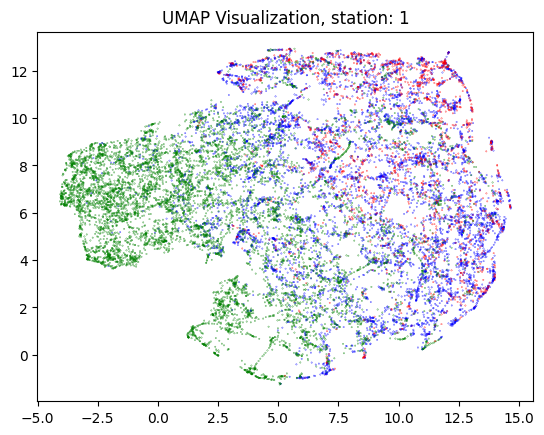

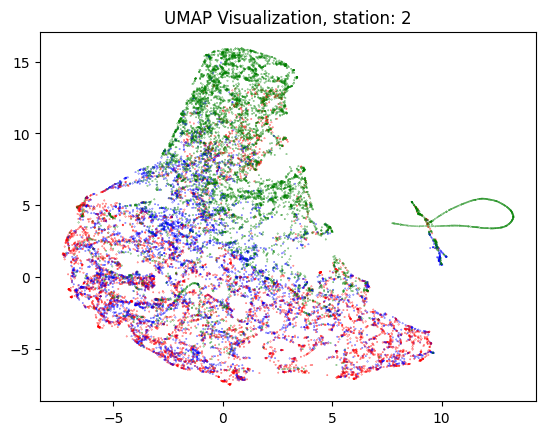

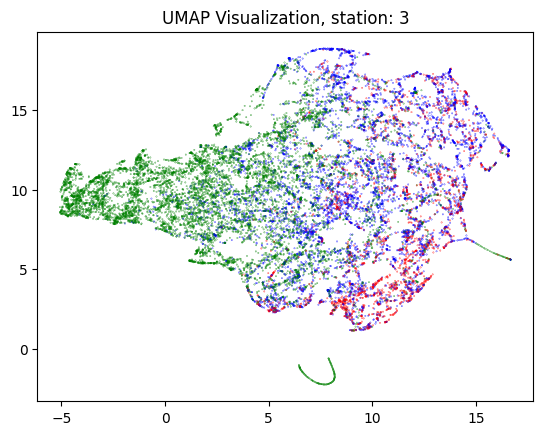

In [ ]:
plot_umap_by_station(df, [1, 2, 3])

In [ ]:
# Put leaf_wetness on the first place
column_to_move = df['leaf_wetness']
df = df.drop(columns='leaf_wetness')
df.insert(0, 'leaf_wetness', column_to_move)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [ ]:
# Simple Linear Regression without previous classification
def build_regression(df, station_ids):
  for station_id in station_ids:
    grouped = df.groupby('datasource_id')
    group = grouped.get_group(station_id)

    scaler = MinMaxScaler()
    data_norm = scaler.fit_transform(group)

    X_train, X_test, y_train, y_test = train_test_split(data_norm[:, 1:], data_norm[:, 0], test_size=0.2, random_state=42)

    regression_model = LinearRegression()
    regression_model.fit(X_train, y_train)
    y_pred = regression_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)
    print("For station ", station_id, "r2=" + str(r2))

In [ ]:
build_regression(df, df.reset_index('datasource_id', drop=False)['datasource_id'].unique())

For station  1.0 r2=0.3839553707036678
For station  2.0 r2=0.3754647975620594
For station  3.0 r2=0.39445384561559715
For station  9.0 r2=0.3679510499952344
For station  13.0 r2=0.2866470403607182
For station  14.0 r2=0.40754932547544864
For station  15.0 r2=0.2833966781923044
For station  28.0 r2=0.5515022167665036
For station  29.0 r2=0.1723773339037381
For station  30.0 r2=0.08040710964610687


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#Decision tree to classify leaf_wetness == 0 and leaf_wetness > 0

def build_decision_tree(df, stations_ids):
  for station_id in stations_ids:
    grouped = df.groupby('datasource_id')
    group = grouped.get_group(station_id)

    X = group.drop('leaf_wetness', axis=1)
    y = group['leaf_wetness'].apply(lambda x: 1 if x > 0 else 0)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create and fit the decision tree classifier
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy for station", str(station_id) + ': ' + str(accuracy))

In [ ]:
build_decision_tree(df, df.reset_index('datasource_id', drop=False)['datasource_id'].unique())

Accuracy for station 1.0: 0.799258625605931
Accuracy for station 2.0: 0.7970353477765109
Accuracy for station 3.0: 0.8195553021664767
Accuracy for station 9.0: 0.7736602052451539
Accuracy for station 13.0: 0.8261117445838084
Accuracy for station 14.0: 0.8363273453093812
Accuracy for station 15.0: 0.8064975776574522
Accuracy for station 28.0: 0.87884834663626
Accuracy for station 29.0: 0.7880870561282932
Accuracy for station 30.0: 0.8288340034462952
